# 1. Introduction
This notebook consists of 6 sections
1. Introduction
2. A description of the problem and a discussion of the background.
3. A description of the data and how it will be used to solve the problem.2. 
4. Collecting and visualizing city data
5. Merging and comparing cities data
6. Conclusion


# 2. A description of the problem and a discussion of the background.
## 2.1 Background
I am running consulting business with my data science expertise. One of our business client asked me he wants to make money by investing some money in major city. More concretely, he wants to open a restaurant in major city.

After several meetings, we narrowed down our options to three cities, Tokyo, New York and Toronto. As a high level understanding, he said he wants to compare the neighborhoods of the three cities and determine how similar or dissimilar they are. Is New York City more like Toronto or Tokyo etc.

## 2.2 Problem setting
I, as a data scientist, will provide following supporting information so that my business client can make a decision which city he should invest. <br>
1.2.1 Compare veneus categories of the three cities, and determine how similar or dissimilar they are.  <br>
1.2.2 Find popular and dispopular venue categories in each cities, using population and area data.


# 3. A description of the data and how it will be used to solve the problem.
## 3.1 Data
I started from collecting venue categories from major neighborhood in each city. 
Then, using Foursquare API, acquire venue category data in each neighborhood and create data table of venue category of cities.
In addition to category data, city population and area data will be used. <br>
2.1.1 Venue category of Neighborhood in each city
2.1.2 Population and area data of cities

## 3.2 How it will be used to solve the problem? 
First of all, number of venue categories are grouped by city. Categories are normalized by total venues.
Venue category data of three cities are merged into one dataframe (columns are cities), so that we can compare categories of cities. Here I only used categories which are NOT NaN in the dataframe. <br>
Category dataframe is examined, normilized by using population and area data to compare among cities.


# 4. Collecting and visualizing city data

Install packages

In [317]:
#!pip install folium
#!pip3 install KMeans
#!pip install geopy

Import default packages

In [318]:
import numpy as np

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import folium

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

# Beautifulsoap
from bs4 import BeautifulSoup

print('Libraries imported.')

Libraries imported.


## 4.1. Creating and visualizing Toronto data

In [319]:
website_url = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text

soup = BeautifulSoup(website_url,'html.parser')
My_table = soup.find('table',{'class':'wikitable sortable'})
lt = pd.read_html(str(My_table))
df = lt[0]
df = df.rename(columns={0:"Postal Code", 1:"Borough", 2:"Neighborhood"})
df1 = df.drop(0,axis=0).reset_index(drop=True)
df1.head()
#df1 = df[df.Borough != 'Not assigned']
#df1[df1.Neighborhood == 'Not assigned']

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


2. Download Geodata

In [320]:
url = "http://cocl.us/Geospatial_data"
geodf = pd.read_csv(url)
df2 = df1.join(geodf.set_index('Postal Code'), on='Postal Code')
df3 = df2[df2['Borough'].str.contains('Toronto')]

toronto_data = df2[df2['Borough'].str.contains('Toronto')].reset_index(drop=True)
toronto_data.head()
neighborhood_latitude = toronto_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = toronto_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = toronto_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Regent Park, Harbourfront are 43.6542599, -79.3606359.


3. Credential information for using foursquare

In [321]:
# type your answer here
CLIENT_ID = 'UFMC4P3J35E05A0KYJJW0KR455IBIXSCHHSZRICLJZGOZ4FW' # your Foursquare ID
CLIENT_SECRET = 'QIBETEZDQHSLZMJ2DGBQHCB01Q5VCKXDE4YQYSW0BNWVVKCM' # your Foursquare Secret
ACCESS_TOKEN = 'MQX3OFQXNV5VAIUQFVIV0KWD3E05APR02HBF3PK4JQEKH11B' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: UFMC4P3J35E05A0KYJJW0KR455IBIXSCHHSZRICLJZGOZ4FW
CLIENT_SECRET:QIBETEZDQHSLZMJ2DGBQHCB01Q5VCKXDE4YQYSW0BNWVVKCM


4. Define function for foursquare API

In [322]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name, lat, lng)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

5. Create toronto venue dataframe

In [323]:
toronto_venues = getNearbyVenues(toronto_data.Neighborhood, toronto_data.Latitude, toronto_data.Longitude)
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

#toronto_onehot.head()

toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
#toronto_grouped

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Bakery,Beer Bar,Farmers Market,Seafood Restaurant,Cheese Shop,Pharmacy,Restaurant,Italian Restaurant
1,"Brockton, Parkdale Village, Exhibition Place",Café,Coffee Shop,Breakfast Spot,Bakery,Convenience Store,Performing Arts Venue,Pet Store,Climbing Gym,Restaurant,Burrito Place
2,"Business reply mail Processing Centre, South C...",Yoga Studio,Auto Workshop,Garden Center,Gym / Fitness Center,Garden,Fast Food Restaurant,Farmers Market,Light Rail Station,Comic Shop,Pizza Place
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Lounge,Airport Terminal,Coffee Shop,Harbor / Marina,Rental Car Location,Sculpture Garden,Boutique,Bar,Boat or Ferry
4,Central Bay Street,Coffee Shop,Sandwich Place,Italian Restaurant,Café,Salad Place,Burger Joint,Thai Restaurant,Bubble Tea Shop,Poke Place,Park


6. Create clusters

In [324]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_data

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
toronto_merged.head()

#k=5
#toronto_clustering = toronto_data.drop(['Postal Code','Borough','Neighborhood'],1)
#kmeans = KMeans(n_clusters = k,random_state=0).fit(toronto_clustering)
#kmeans.labels_
#toronto_data.insert(0, 'Cluster Labels', kmeans.labels_)

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,Coffee Shop,Pub,Park,Café,Bakery,Restaurant,Theater,Breakfast Spot,Brewery,Spa
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0,Coffee Shop,Sushi Restaurant,Yoga Studio,Burrito Place,Bar,Smoothie Shop,Beer Bar,Italian Restaurant,Sandwich Place,Café
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0,Clothing Store,Coffee Shop,Café,Cosmetics Shop,Bubble Tea Shop,Middle Eastern Restaurant,Japanese Restaurant,Pizza Place,Lingerie Store,Ramen Restaurant
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0,Coffee Shop,Café,Cocktail Bar,Clothing Store,Cosmetics Shop,American Restaurant,Moroccan Restaurant,Cheese Shop,Park,Lingerie Store
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Coffee Shop,Trail,Health Food Store,Pub,Dance Studio,Electronics Store,Eastern European Restaurant,Donut Shop,Doner Restaurant,Dog Run


7. Create visual map

In [325]:
address = 'Toronto'
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = neighborhood_latitude
longitude = neighborhood_longitude

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        #color = rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [326]:
## create map
#map_clusters = folium.Map(location=[43.651070,-79.347015],zoom_start=10)
#
## set color scheme for the clusters
#x = np.arange(k)
#ys = [i + x + (i*x)**2 for i in range(k)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]
#
## add markers to the map
#markers_colors = []
#for lat, lon, neighbourhood, cluster in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Neighborhood'], toronto_data['Cluster Labels']):
#    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
#    folium.CircleMarker(
#        [lat, lon],
#       radius=5,
#        popup=label,
#        color=rainbow[cluster-1],
#        fill=True,
#        fill_color=rainbow[cluster-1],
#        fill_opacity=0.7).add_to(map_clusters)
#       
#map_clusters

## 4.2 Creating and visualizing Tokyo data

In [327]:
website_url = requests.get('https://en.wikipedia.org/wiki/Special_wards_of_Tokyo').text

soup = BeautifulSoup(website_url,'html.parser')
My_table = soup.find('table',{'class':'wikitable sortable'})
lt = pd.read_html(str(My_table))
df = lt[0]
df = df.rename(columns={0:"No.", 1:"Flag", 2:"Name", 3:"Kanji", 4:"Polupation", 5:"Density", 6:"Area", 7:"Major districts"})
df = df.drop([0,23], axis=0)
df.head()

,No.,Flag,Name,Kanji,Polupation,Density,Area,Major districts
1,01,NaN,Chiyoda,千代田区,0059441,05100,011.66,"Nagatachō, Kasumigaseki, Ōtemachi, Marunouchi,..."
2,02,NaN,Chūō,中央区,0147620,14460,010.21,"Nihonbashi, Kayabachō, Ginza, Tsukiji, Hatchōb..."
3,03,NaN,Minato,港区,0248071,12180,020.37,"Odaiba, Shinbashi, Hamamatsuchō, Mita, Roppong..."
4,04,NaN,Shinjuku,新宿区,0339211,18620,018.22,"Shinjuku, Takadanobaba, Ōkubo, Kagurazaka, Ich..."
5,05,NaN,Bunkyō,文京区,0223389,19790,011.29,"Hongō, Yayoi, Hakusan"


In [328]:
path = "Tokyo.xlsx"
tokyo_data = pd.read_excel(path)
tokyo_data

,Borough,Neighborhood,Latitude,Longitude
0,Chiyoda,Nagatachō,35.675618,139.743469
1,Chiyoda,Kasumigaseki,35.674054,139.750972
2,Chiyoda,Ōtemachi,35.686779,139.763564
3,Chiyoda,Marunouchi,35.680656,139.765222
4,Chiyoda,Akihabara,35.699736,139.771250
5,Chiyoda,Yūrakuchō,35.674423,139.761674
6,Chiyoda,Iidabashi,35.701374,139.744445
7,Chiyoda,Kanda,29.845427,79.936388
8,Chūō,Nihonbashi,35.684068,139.774503
9,Chūō,Kayabachō,35.680229,139.779424


Create Tokyo_data dataframe

In [329]:
#column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude']
#tokyo_data = pd.DataFrame(columns=column_names)
#for index in df.index:
#    Neighbors = [x.strip() for x in df.at[index,'Major districts'].split(',')]
#    for nei in Neighbors:
#        #print(df.at[index,'Name'], nei, geolocator.geocode(nei).latitude, geolocator.geocode(nei).longitude)
#        tokyo_data = tokyo_data.append({'Borough': df.at[index,'Name'], 'Neighborhood': nei, 'Latitude': geolocator.geocode(nei).latitude, 'Longitude': geolocator.geocode(nei).longitude}, ignore_index=True)


In [330]:
tokyo_data

,Borough,Neighborhood,Latitude,Longitude
0,Chiyoda,Nagatachō,35.675618,139.743469
1,Chiyoda,Kasumigaseki,35.674054,139.750972
2,Chiyoda,Ōtemachi,35.686779,139.763564
3,Chiyoda,Marunouchi,35.680656,139.765222
4,Chiyoda,Akihabara,35.699736,139.771250
5,Chiyoda,Yūrakuchō,35.674423,139.761674
6,Chiyoda,Iidabashi,35.701374,139.744445
7,Chiyoda,Kanda,29.845427,79.936388
8,Chūō,Nihonbashi,35.684068,139.774503
9,Chūō,Kayabachō,35.680229,139.779424


In [331]:
tokyo_venues = getNearbyVenues(tokyo_data.Neighborhood, tokyo_data.Latitude, tokyo_data.Longitude)
# one hot encoding
tokyo_onehot = pd.get_dummies(tokyo_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
tokyo_onehot['Neighborhood'] = tokyo_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [tokyo_onehot.columns[-1]] + list(tokyo_onehot.columns[:-1])
tokyo_onehot = tokyo_onehot[fixed_columns]

#tokyo_onehot.head()

tokyo_grouped = tokyo_onehot.groupby('Neighborhood').mean().reset_index()
#tokyo_grouped

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = tokyo_grouped['Neighborhood']

for ind in np.arange(tokyo_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(tokyo_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Akabane,Sake Bar,Convenience Store,Ramen Restaurant,BBQ Joint,Café,Soba Restaurant,Clothing Store,Coffee Shop,Bar,Shopping Mall
1,Akihabara,Hobby Shop,Electronics Store,Café,Ramen Restaurant,Donburi Restaurant,Arcade,Rock Club,Toy / Game Store,Comic Shop,Tonkatsu Restaurant
2,Aobadai,Ramen Restaurant,Park,Grocery Store,Convenience Store,Clothing Store,BBQ Joint,Discount Store,Coffee Shop,Fast Food Restaurant,Soba Restaurant
3,Aomi,Exhibit,Convenience Store,Plaza,Park,Coffee Shop,Bookstore,Shopping Mall,Theme Restaurant,Theme Park Ride / Attraction,Theme Park
4,Aoto,Convenience Store,Sake Bar,Chinese Restaurant,Concert Hall,Italian Restaurant,Rental Car Location,Café,Takoyaki Place,Mobile Phone Shop,Sushi Restaurant


In [332]:
# set number of clusters
kclusters = 5

tokyo_grouped_clustering = tokyo_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(tokyo_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

tokyo_merged = tokyo_data

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
tokyo_merged = tokyo_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
tokyo_merged = tokyo_merged.dropna()
tokyo_merged.head()

#k=5
#tokyo_clustering = tokyo_data.drop(['Postal Code','Borough','Neighborhood'],1)
#kmeans = KMeans(n_clusters = k,random_state=0).fit(tokyo_clustering)
#kmeans.labels_
#tokyo_data.insert(0, 'Cluster Labels', kmeans.labels_)

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Chiyoda,Nagatachō,35.675618,139.743469,3.0,Convenience Store,Coffee Shop,Japanese Restaurant,Intersection,Hotel,Sushi Restaurant,Supermarket,Sports Club,Cafeteria,Soba Restaurant
1,Chiyoda,Kasumigaseki,35.674054,139.750972,3.0,Convenience Store,Historic Site,Concert Hall,Lawyer,Bookstore,Japanese Restaurant,Coffee Shop,Restaurant,Ramen Restaurant,Café
2,Chiyoda,Ōtemachi,35.686779,139.763564,1.0,Café,Japanese Restaurant,Coffee Shop,Italian Restaurant,Hotel,Chinese Restaurant,Historic Site,Lounge,Udon Restaurant,Convenience Store
3,Chiyoda,Marunouchi,35.680656,139.765222,1.0,Japanese Restaurant,Café,Deli / Bodega,Chinese Restaurant,Hotel,Gourmet Shop,Ramen Restaurant,Furniture / Home Store,Steakhouse,Gift Shop
4,Chiyoda,Akihabara,35.699736,139.771250,1.0,Hobby Shop,Electronics Store,Café,Ramen Restaurant,Donburi Restaurant,Arcade,Rock Club,Toy / Game Store,Comic Shop,Tonkatsu Restaurant


In [333]:
address = 'Tokyo'
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tokyo_merged['Latitude'], tokyo_merged['Longitude'], tokyo_merged['Neighborhood'], tokyo_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        #color = rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 4.3 Creating and visualizing New York data

In [335]:
with open('nyu_2451_34572-geojson.json') as json_data:
    newyork_data = json.load(json_data)

In [336]:
neighborhoods_data = newyork_data['features']

In [337]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [338]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [339]:
address = 'New York City, NY'
#address = 'Los Angeles, CA'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [363]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
#map_newyork

In [341]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [342]:
manhattan_venues = getNearbyVenues(manhattan_data.Neighborhood, manhattan_data.Latitude, manhattan_data.Longitude)
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

#manhattan_onehot.head()

manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
#manhattan_grouped

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
mhn_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
mhn_neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    mhn_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

mhn_neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Coffee Shop,Park,Hotel,Clothing Store,Memorial Site,Gym,Boat or Ferry,Playground,Pizza Place,Cupcake Shop
1,Carnegie Hill,Coffee Shop,Café,Bar,Pizza Place,French Restaurant,Bookstore,Yoga Studio,Gym,Gym / Fitness Center,Wine Shop
2,Central Harlem,Seafood Restaurant,American Restaurant,Gym / Fitness Center,Chinese Restaurant,French Restaurant,African Restaurant,Bar,Cafeteria,Caribbean Restaurant,Event Space
3,Chelsea,Coffee Shop,Bakery,Art Gallery,American Restaurant,French Restaurant,Hotel,Wine Shop,Italian Restaurant,Market,Cycle Studio
4,Chinatown,Chinese Restaurant,Bakery,Cocktail Bar,American Restaurant,Optical Shop,Spa,Salon / Barbershop,Bar,Sandwich Place,Dim Sum Restaurant


In [343]:
# set number of clusters
kclusters = 5

manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)

# run k-means clustering
mhn_kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
mhn_kmeans.labels_[0:10]

# add clustering labels
mhn_neighborhoods_venues_sorted.insert(0, 'Cluster Labels', mhn_kmeans.labels_)

manhattan_merged = manhattan_data

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(mhn_neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
manhattan_merged = manhattan_merged.dropna()
manhattan_merged.head()

#k=5
#manhattan_clustering = manhattan_data.drop(['Postal Code','Borough','Neighborhood'],1)
#kmeans = KMeans(n_clusters = k,random_state=0).fit(manhattan_clustering)
#kmeans.labels_
#manhattan_data.insert(0, 'Cluster Labels', kmeans.labels_)

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,3,Discount Store,Coffee Shop,Sandwich Place,Gym,Yoga Studio,Tennis Stadium,Deli / Bodega,Pizza Place,Department Store,Diner
1,Manhattan,Chinatown,40.715618,-73.994279,1,Chinese Restaurant,Bakery,Cocktail Bar,American Restaurant,Optical Shop,Spa,Salon / Barbershop,Bar,Sandwich Place,Dim Sum Restaurant
2,Manhattan,Washington Heights,40.851903,-73.936900,4,Café,Spanish Restaurant,Bakery,Mobile Phone Shop,Bank,Grocery Store,Latin American Restaurant,Deli / Bodega,Chinese Restaurant,Sandwich Place
3,Manhattan,Inwood,40.867684,-73.921210,4,Mexican Restaurant,Lounge,Restaurant,Café,Spanish Restaurant,Caribbean Restaurant,Frozen Yogurt Shop,Park,Deli / Bodega,Chinese Restaurant
4,Manhattan,Hamilton Heights,40.823604,-73.949688,4,Pizza Place,Coffee Shop,Mexican Restaurant,Café,Deli / Bodega,Cocktail Bar,Indian Restaurant,Sushi Restaurant,Park,Yoga Studio


In [344]:
address = 'Manhattan'
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        #color = rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# 4.4 City population and area data

In [ ]:
#dfm.loc['Population(m)'] = [9.68, 2.93, 1.62]
#dfm.loc['Area(km2)'] = [627.6, 630.2, 59.2]
#dfm.loc['Density(mpp/km2)'] = dfm.loc['Population(m)']  / dfm.loc['Area(km2)'] = [0.015424, 0.004649, 0.027365]

# 5. Merging and comparing cities data

In [356]:
n = 50
tokyo_df = tokyo_onehot.groupby('Neighborhood').sum().sum()
tokyo_df1 = (tokyo_df/tokyo_df.sum()).sort_values(ascending=False).head(n)
toronto_df = toronto_onehot.groupby('Neighborhood').sum().sum()
toronto_df1 = (toronto_df/toronto_df.sum()).sort_values(ascending=False).head(n)
manhattan_df = manhattan_onehot.groupby('Neighborhood').sum().sum()
manhattan_df1 = (manhattan_df/manhattan_df.sum()).sort_values(ascending=False).head(n)

dfm = pd.concat([tokyo_df1, toronto_df1, manhattan_df1],axis=1,sort=False)

dfm.fillna(0)
dfm = dfm.rename(columns={0:'Tokyo', 1:'Toronto', 2:'Manhattan'})
dfm.loc['Coffee Shop'] = dfm.loc['Coffee Shop'] + dfm.loc['Café']
dfm = dfm.drop('Café')

Check ratio of 'Restaurant' venue in total venues <br>
--> there is not so much difference in cities, roughly 19~23%

In [358]:
print('Ratio of Tokyo', len([s for s in tokyo_onehot.columns.tolist() if 'Restaurant' in s])/tokyo_onehot.groupby('Neighborhood').sum().shape[1])
print('Ratio of Toronto', len([s for s in toronto_onehot.columns.tolist() if 'Restaurant' in s])/toronto_onehot.groupby('Neighborhood').sum().shape[1])
print('Ratio of Manhattan', len([s for s in manhattan_onehot.columns.tolist() if 'Restaurant' in s])/manhattan_onehot.groupby('Neighborhood').sum().shape[1])

Ratio of Tokyo 0.22686567164179106
Ratio of Toronto 0.1894273127753304
Ratio of Manhattan 0.21450151057401812


Create data tables, using population and area data

In [350]:
dfmbypop = dfm.copy()
dfmbydens = dfm.copy()
dfmbyarea = dfm.copy()
dfmbypop['Tokyo'] = dfm['Tokyo']/9.68
dfmbypop['Toronto'] = dfm['Toronto']/2.93
dfmbypop['Manhattan'] = dfm['Manhattan']/1.62
dfmbydens['Tokyo'] = dfm['Tokyo']/0.015424
dfmbydens['Toronto'] = dfm['Toronto']/0.004649
dfmbydens['Manhattan'] = dfm['Manhattan']/0.027365
dfmbyarea['Tokyo'] = dfm['Tokyo']/626.6
dfmbyarea['Toronto'] = dfm['Toronto']/630.2
dfmbyarea['Manhattan'] = dfm['Manhattan']/59.2
#dfmbypop = dfm.drop(['Café','Area(km2)','Population(m)','Density(mpp/km2)'], axis=0)
#dfm1.loc['Coffee Shop'] = dfm.loc['Coffee Shop']/dfm.loc['Population(m)']

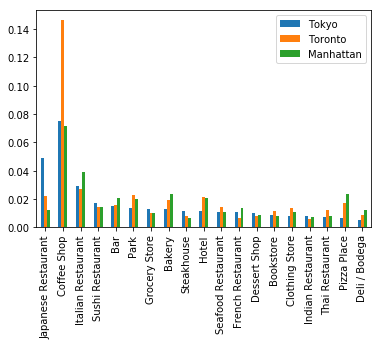

In [359]:
# show normalized venue category bar plot/
dfm.dropna().plot.bar()

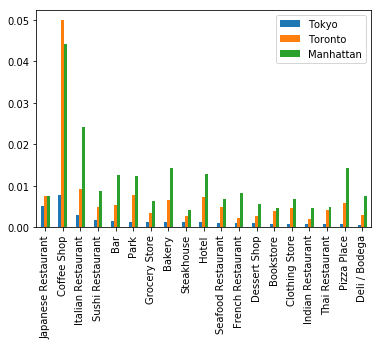

In [351]:
# devided by population
dfmbypop.dropna().plot.bar()

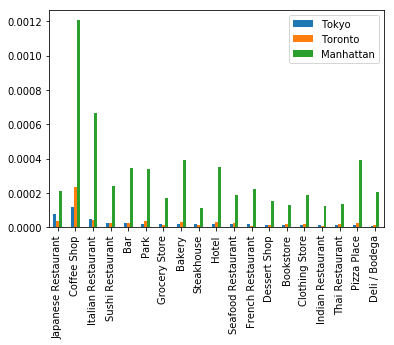

In [360]:
# devided by area
dfmbyarea.dropna().plot.bar()

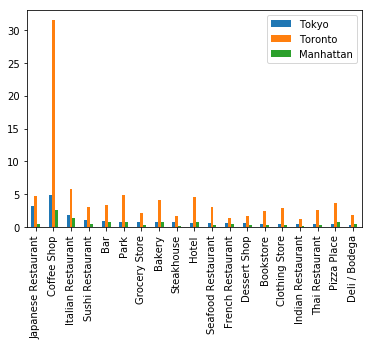

In [361]:
# devided by population density
dfmbydens.dropna().plot.bar()

# 6. Conclusion
Here are findings from available dataset;
6.1 There is not so much difference in ratio of 'Restaurant' venue against total venues among cities, roughly 19~23%.
6.2 There are way more coffee shops than Tokyo and Mahnattan, it is obvious if it is devided by population density.
6.3 Manhattan is very compact city compared to Tokyo and Toronto.
6.4 Relatively, there are more Italian restaurant in Manhattan than Tokyo and Toronto.
6.5 Relatively, ratio of venues devided population is less in Tokyo than Toronto and Manhattan, except Japanese restaurant.
<br><br>

As a conslution, <br>
If you select Tokyo city, it is suggested to avoid Japanese restaurant and coffee shop. Other cuisine may have better chance for grow. <br>
If you select Toronto city, it is suggested to avoid coffee shop because there are too many of them already. Also you may struggle to find good location because density ratios are very high in any category.
If you select Manhattan city, it is suggested to avoid Italian restaurant because there are too many of them already. Also you may struggle to find good location because area ratios are very high in any category.
